In [54]:
%load_ext autoreload
# always reload modules marked with "%aimport"
%autoreload 1

import os,sys
import numpy as np
import pandas as pd

# add the 'src' directory as one where we can import modules
src_dir = os.path.join(os.getcwd(), '../..', 'src')
sys.path.append(src_dir)

%aimport plot_utils
from plot_utils import *
%aimport preprocessing
from preprocessing import *
%aimport data_source
from data_source import *
%aimport model_manage
from model_manage import *
%aimport model_regression
from model_regression import *
%aimport multi_segment_regressor
from multi_segment_regressor import *

import logging
from utils import *
set_logger(logging.INFO)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import pandas as pd
import numpy as np

from sklearn import linear_model
from sklearn import model_selection
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import ElasticNet

In [3]:
ds = DataSource(host='localhost',port=5432, username='postgres', password='', database='sdra')
ds.show_views()
#ds.update_views()

[dp] connect to database postgresql://postgres:@localhost:5432/sdra
[dp] supported views: ['properties', 'property_features', 'transactions', 'property_addresses', 'property_address_transactions', 'property_transaction_valid', 'property_address_school_transactions', 'property_address_schools']


In [4]:
df_transaction = ds.get_view_df('property_address_school_transactions')
df_property = ds.get_view_df('property_address_schools')
print(df_transaction.shape)
print(df_property.shape)

(1477830, 37)
(710576, 34)


In [5]:
pp = Preprocess(df_transaction, df_property, target='sold_price')

In [8]:
use_features = pp.get_feature_list()
school_features = ['sqft_over_zip_avg','eval_over_zip_avg', 
                   'min_elem_distance', 'min_middle_distance', 'min_high_distance',
                   'elem_rating', 'middle_rating', 'high_rating',
                   'avg_elem_rating', 'avg_high_rating', 'avg_middle_rating']
use_features_base = ['date', 'pool', 'num_bed', 'view', 'num_bath', 'impr_over_land', 'sqft',
                     'sold_price_zip_avg', 'sqft_price_zip_avg', 
                     # 'sqft_zip_avg', 'eval_zip_avg', 
                     'lon', 'lat']
use_features_base

['date',
 'pool',
 'num_bed',
 'view',
 'num_bath',
 'impr_over_land',
 'sqft',
 'sold_price_zip_avg',
 'sqft_price_zip_avg',
 'lon',
 'lat']

## regression on dateset of all time long

### baseline

In [ ]:
df_all = pp.dataset(feature='delivered', valid=True, date=('1985-10-01', '2017-10-01'))

In [18]:
rf = RandomForestRegressor(n_estimators=100, max_depth=14, n_jobs=-1, random_state=17)
rf_mini = RandomForestRegressor(n_estimators=20, max_depth=12, n_jobs=-1, random_state=17)
mr_full = ModelRegression(use_features_base, rf)
mr_full_mini = ModelRegression(use_features_base, rf_mini)

In [ ]:
### regress with 12-month sliding window
mr_full_mini.regress(df_all, sliding_window=12)
df_baseline_12_mini = mr_full_mini.summary()

In [31]:
df_baseline_12_mini.columns = ['error_baseline', 'window_baseline']
df_baseline_12_mini.to_csv('c:\\wenyan\\dse_capstone\\notebooks\\modeling\\dump\\regress_baseline_12_mini.csv')

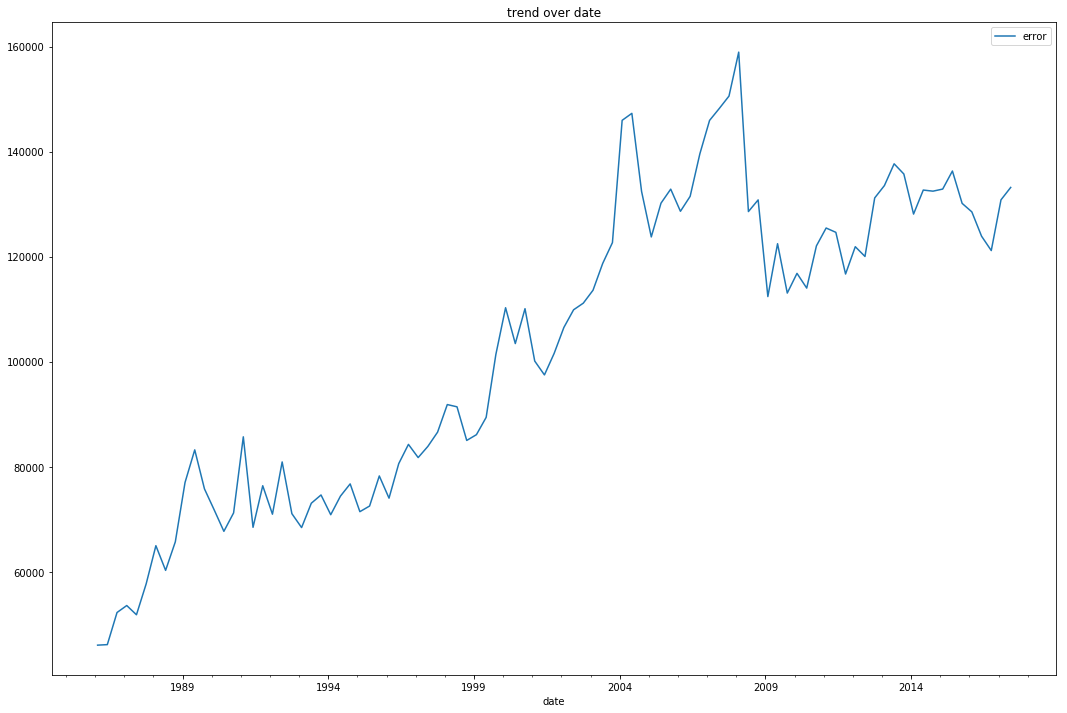

In [21]:
plot_trends(df_baseline_12_mini, ['error'])

In [ ]:
### regress with 4-month sliding window
mr_full_mini.regress(df_all, sliding_window=4)
df_baseline_4_mini = mr_full_mini.summary()

df_baseline_4_mini.columns = ['error_baseline_4', 'window_baseline_4']
df_baseline_4_mini.to_csv('c:\\wenyan\\dse_capstone\\notebooks\\modeling\\dump\\regress_baseline_4_mini.csv')

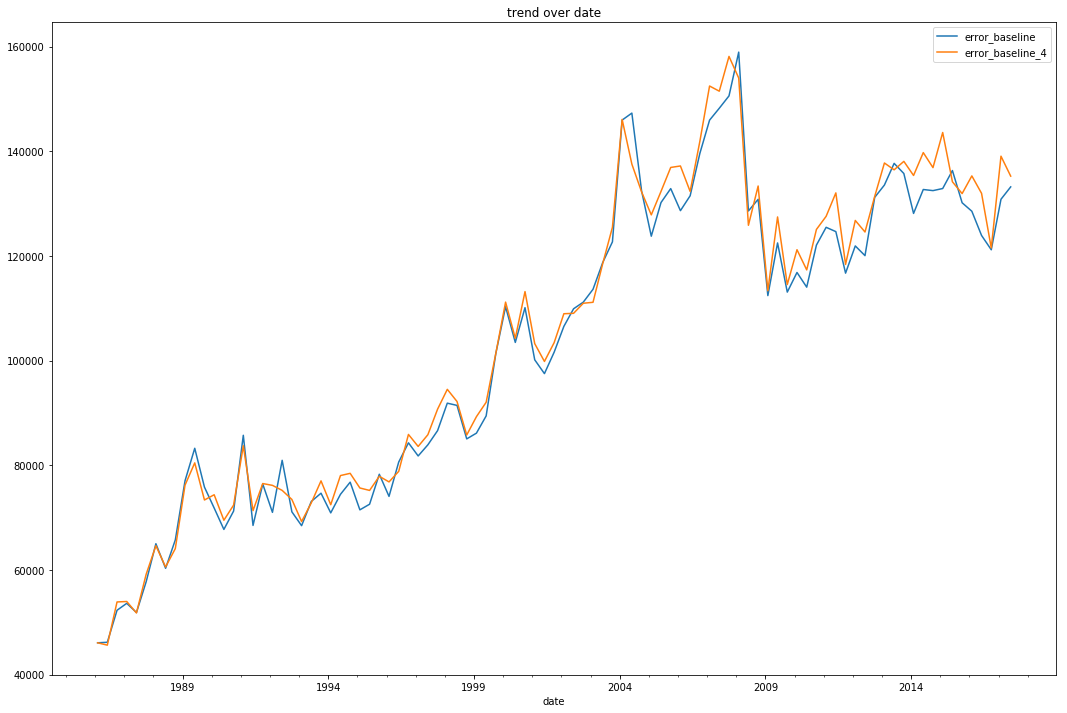

In [39]:
df_cmp = df_baseline_4_mini.join(df_baseline_12_mini)
plot_trends(df_cmp, ['error_baseline', 'error_baseline_4'])

### baseline + clean (outliers)

In [40]:
df_all_clean = pp.dataset(feature='delivered', valid=True, clean=True, date=('1985-10-01', '2017-10-01'))

In [41]:
mr_full_mini.regress(df_all_clean, sliding_window=4)
df_clean_4_mini = mr_full_mini.summary()
df_clean_4_mini.columns = ['error_clean_4', 'window_clean_4']
df_clean_4_mini.to_csv('c:\\wenyan\\dse_capstone\\notebooks\\modeling\\dump\\regress_clean_4_mini.csv')

[dp] train and predict - period: 1985-10-01 ~ 1986-05-30, sliding(in month): 4, test: 4, data shape: (25910, 27)
[dp] track/sliding/test window size: 13327, 0, 12583
[dp] training data size: (13327, 10)
[dp] test data size: (12583, 10)
[dp] train and predict - period: 1986-02-03 ~ 1986-09-30, sliding(in month): 4, test: 4, data shape: (29830, 27)
[dp] track/sliding/test window size: 12199, 0, 17631
[dp] training data size: (12199, 10)
[dp] test data size: (17631, 10)
[dp] train and predict - period: 1986-06-02 ~ 1987-01-30, sliding(in month): 4, test: 4, data shape: (35699, 27)
[dp] track/sliding/test window size: 17631, 0, 18068
[dp] training data size: (17631, 10)
[dp] test data size: (18068, 10)
[dp] train and predict - period: 1986-10-01 ~ 1987-05-29, sliding(in month): 4, test: 4, data shape: (33170, 27)
[dp] track/sliding/test window size: 17713, 0, 15457
[dp] training data size: (17713, 10)
[dp] test data size: (15457, 10)
[dp] train and predict - period: 1987-02-02 ~ 1987-09-30

[dp] train and predict - period: 1997-06-02 ~ 1998-01-30, sliding(in month): 4, test: 4, data shape: (26842, 27)
[dp] track/sliding/test window size: 14076, 0, 12766
[dp] training data size: (14076, 10)
[dp] test data size: (12766, 10)
[dp] train and predict - period: 1997-10-01 ~ 1998-05-29, sliding(in month): 4, test: 4, data shape: (27670, 27)
[dp] track/sliding/test window size: 12381, 0, 15289
[dp] training data size: (12381, 10)
[dp] test data size: (15289, 10)
[dp] train and predict - period: 1998-02-02 ~ 1998-09-30, sliding(in month): 4, test: 4, data shape: (32801, 27)
[dp] track/sliding/test window size: 14904, 0, 17897
[dp] training data size: (14904, 10)
[dp] test data size: (17897, 10)
[dp] train and predict - period: 1998-06-01 ~ 1999-01-29, sliding(in month): 4, test: 4, data shape: (31938, 27)
[dp] track/sliding/test window size: 17456, 0, 14482
[dp] training data size: (17456, 10)
[dp] test data size: (14482, 10)
[dp] train and predict - period: 1998-10-01 ~ 1999-05-30

[dp] test data size: (10814, 10)
[dp] train and predict - period: 2009-02-02 ~ 2009-09-30, sliding(in month): 4, test: 4, data shape: (23062, 27)
[dp] track/sliding/test window size: 10551, 0, 12511
[dp] training data size: (10551, 10)
[dp] test data size: (12511, 10)
[dp] train and predict - period: 2009-06-01 ~ 2010-01-29, sliding(in month): 4, test: 4, data shape: (23726, 27)
[dp] track/sliding/test window size: 12137, 0, 11589
[dp] training data size: (12137, 10)
[dp] test data size: (11589, 10)
[dp] train and predict - period: 2009-10-01 ~ 2010-05-28, sliding(in month): 4, test: 4, data shape: (22446, 27)
[dp] track/sliding/test window size: 10931, 0, 11515
[dp] training data size: (10931, 10)
[dp] test data size: (11515, 10)
[dp] train and predict - period: 2010-02-01 ~ 2010-09-30, sliding(in month): 4, test: 4, data shape: (22528, 27)
[dp] track/sliding/test window size: 11231, 0, 11297
[dp] training data size: (11231, 10)
[dp] test data size: (11297, 10)
[dp] train and predict 

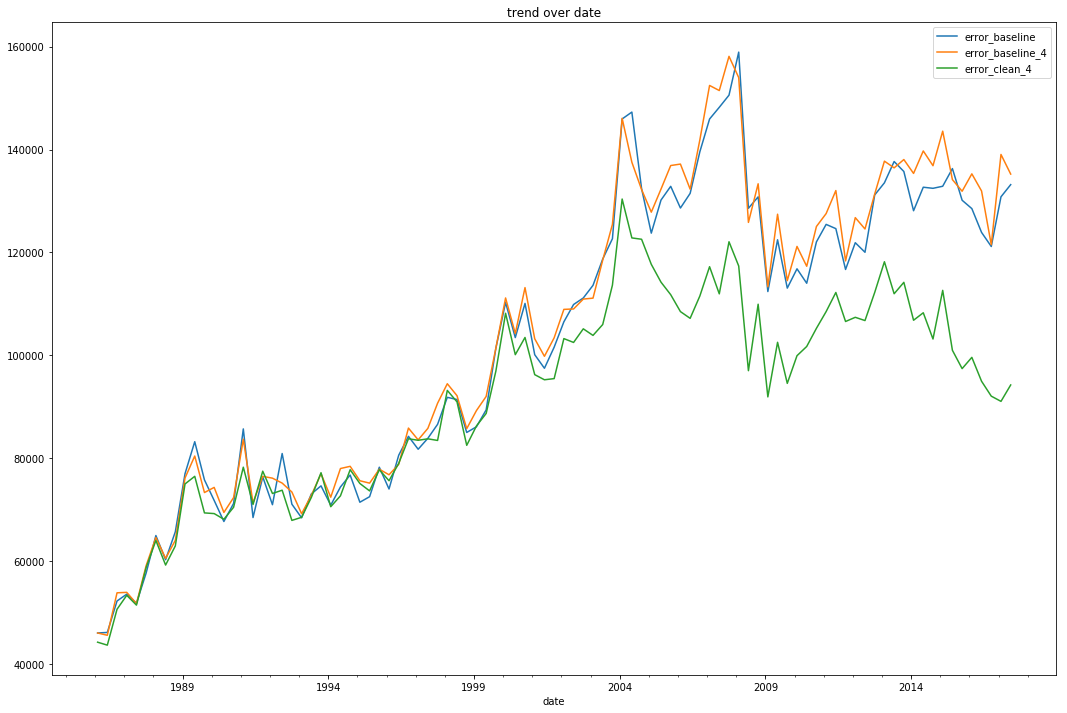

In [43]:
df_cmp = df_cmp.join(df_clean_4_mini)
plot_trends(df_cmp, ['error_baseline', 'error_baseline_4', 'error_clean_4'])

### clean + adv features

In [44]:
df_all_adv_clean = pp.dataset(feature='delivered', valid=True, clean=True, date=('1985-10-01', '2017-10-01'))

In [ ]:
mr_full_adv = ModelRegression(use_features, rf)
mr_full_adv_mini = ModelRegression(use_features, rf_mini)

mr_full_adv_mini.regress(df_all_adv_clean, sliding_window=4)
df_clean_adv_4_mini = mr_full_adv_mini.summary()
df_clean_adv_4_mini.columns = ['error_clean_adv_4', 'window_clean_adv_4']
df_clean_adv_4_mini.to_csv('c:\\wenyan\\dse_capstone\\notebooks\\modeling\\dump\\regress_clean_adv_4_mini.csv')

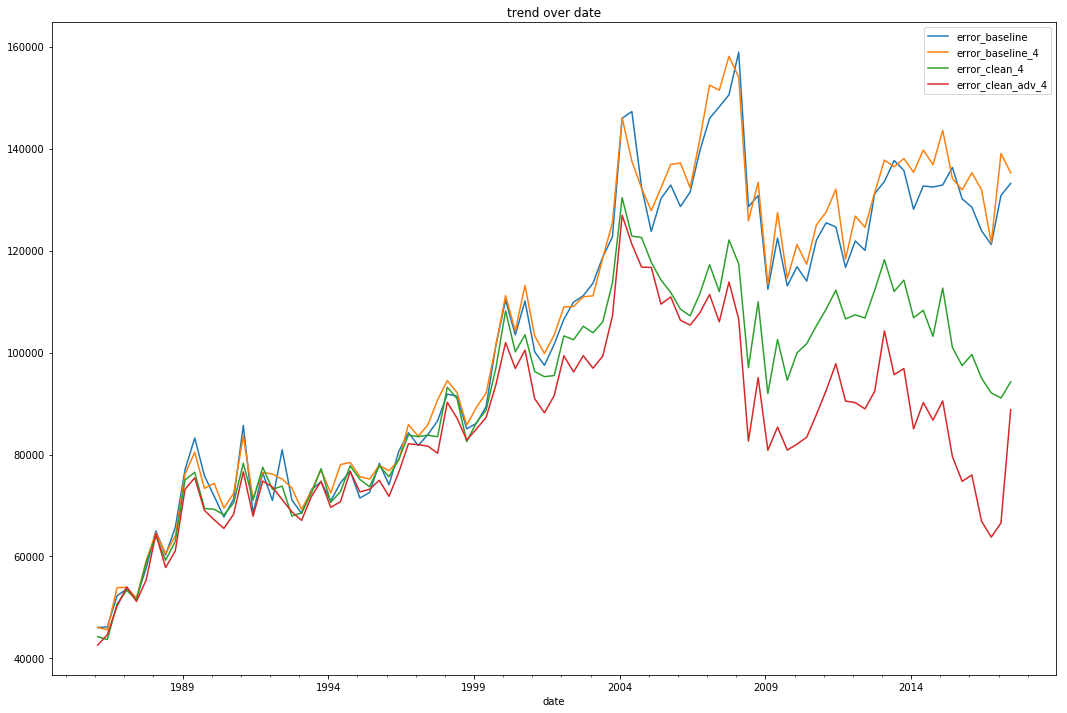

In [50]:
df_cmp = df_cmp.join(df_clean_adv_4_mini)
plot_trends(df_cmp, ['error_baseline', 'error_baseline_4', 'error_clean_4', 'error_clean_adv_4'])

### clean + adv features + 12month sliding window

In [51]:
mr_full_adv_mini.regress(df_all_adv_clean, sliding_window=12)
df_clean_adv_mini = mr_full_adv_mini.summary()
df_clean_adv_mini.columns = ['error_clean_adv', 'window_clean_adv']
df_clean_adv_mini.to_csv('c:\\wenyan\\dse_capstone\\notebooks\\modeling\\dump\\regress_clean_adv_mini.csv')

[dp] train and predict - period: 1985-10-01 ~ 1986-05-30, sliding(in month): 4, test: 4, data shape: (25910, 27)
[dp] track/sliding/test window size: 13327, 0, 12583
[dp] training data size: (13327, 23)
[dp] test data size: (12583, 23)
[dp] train and predict - period: 1985-10-01 ~ 1986-09-30, sliding(in month): 8, test: 4, data shape: (43541, 27)
[dp] track/sliding/test window size: 25910, 13327, 17631
[dp] training data size: (13327, 23)
[dp] test data size: (17631, 23)
[dp] train and predict - period: 1985-10-01 ~ 1987-01-30, sliding(in month): 12, test: 4, data shape: (61609, 27)
[dp] track/sliding/test window size: 43541, 25910, 18068
[dp] training data size: (25910, 23)
[dp] test data size: (18068, 23)
[dp] train and predict - period: 1986-02-03 ~ 1987-05-29, sliding(in month): 12, test: 4, data shape: (63000, 27)
[dp] track/sliding/test window size: 47543, 29469, 15457
[dp] training data size: (29469, 23)
[dp] test data size: (15457, 23)
[dp] train and predict - period: 1986-06-0

[dp] track/sliding/test window size: 25535, 14460, 10581
[dp] training data size: (14460, 23)
[dp] test data size: (10581, 23)
[dp] train and predict - period: 2008-02-01 ~ 2009-05-29, sliding(in month): 12, test: 4, data shape: (40315, 27)
[dp] track/sliding/test window size: 29501, 18893, 10814
[dp] training data size: (18893, 23)
[dp] test data size: (10814, 23)
[dp] train and predict - period: 2008-06-02 ~ 2009-09-30, sliding(in month): 12, test: 4, data shape: (44718, 27)
[dp] track/sliding/test window size: 32207, 21393, 12511
[dp] training data size: (21393, 23)
[dp] test data size: (12511, 23)
[dp] train and predict - period: 2008-10-01 ~ 2010-01-29, sliding(in month): 12, test: 4, data shape: (44858, 27)
[dp] track/sliding/test window size: 33269, 21132, 11589
[dp] training data size: (21132, 23)
[dp] test data size: (11589, 23)
[dp] train and predict - period: 2009-02-02 ~ 2010-05-28, sliding(in month): 12, test: 4, data shape: (45508, 27)
[dp] track/sliding/test window size:

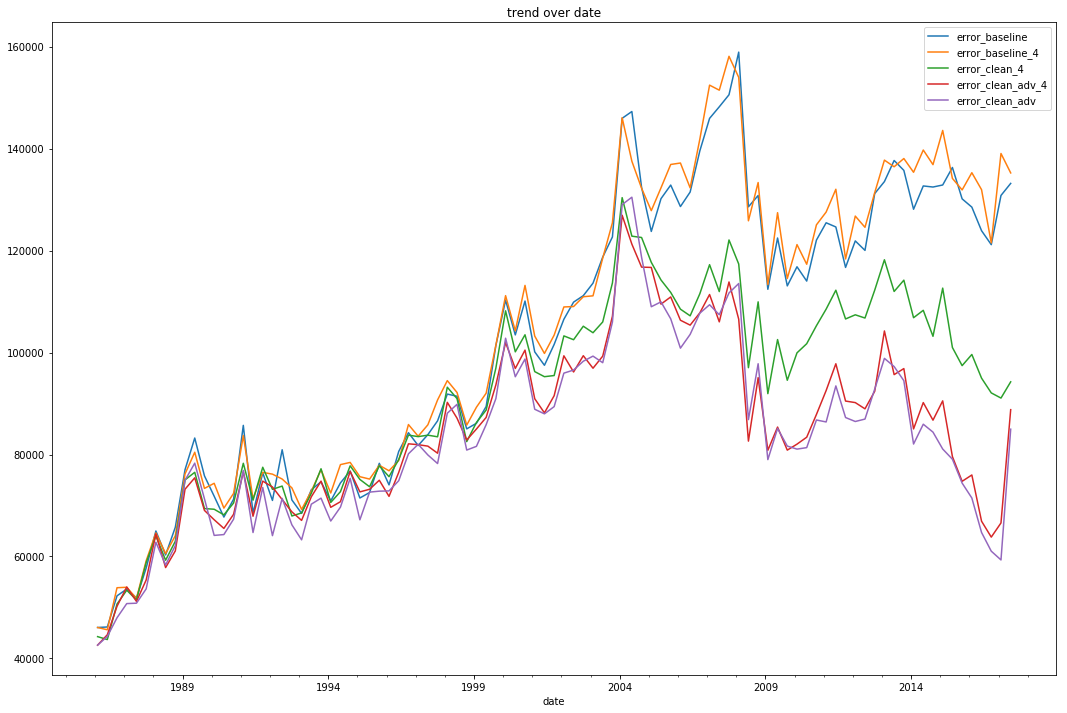

In [52]:
df_cmp = df_cmp.join(df_clean_adv_mini)
plot_trends(df_cmp, ['error_baseline', 'error_baseline_4', 'error_clean_4', 'error_clean_adv_4', 'error_clean_adv'])

### clean + adv features + full rr + 4 sliding

In [74]:
mr_full_adv.regress(df_all_adv_clean, sliding_window=4)
df_clean_adv = mr_full_adv.summary()
df_clean_adv.columns = ['error_clean_adv_full', 'window_clean_adv_full']
df_clean_adv.to_csv('c:\\wenyan\\dse_capstone\\notebooks\\modeling\\dump\\regress_clean_adv.csv')

[dp] train and predict - period: 1985-10-01 ~ 1986-05-30, sliding(in month): 4, test: 4, data shape: (25910, 27)
[dp] track/sliding/test window size: 13327, 0, 12583
[dp] training data size: (13327, 23)
[dp] test data size: (12583, 23)
[dp] train and predict - period: 1986-02-03 ~ 1986-09-30, sliding(in month): 4, test: 4, data shape: (29830, 27)
[dp] track/sliding/test window size: 12199, 0, 17631
[dp] training data size: (12199, 23)
[dp] test data size: (17631, 23)
[dp] train and predict - period: 1986-06-02 ~ 1987-01-30, sliding(in month): 4, test: 4, data shape: (35699, 27)
[dp] track/sliding/test window size: 17631, 0, 18068
[dp] training data size: (17631, 23)
[dp] test data size: (18068, 23)
[dp] train and predict - period: 1986-10-01 ~ 1987-05-29, sliding(in month): 4, test: 4, data shape: (33170, 27)
[dp] track/sliding/test window size: 17713, 0, 15457
[dp] training data size: (17713, 23)
[dp] test data size: (15457, 23)
[dp] train and predict - period: 1987-02-02 ~ 1987-09-30

[dp] train and predict - period: 1997-06-02 ~ 1998-01-30, sliding(in month): 4, test: 4, data shape: (26842, 27)
[dp] track/sliding/test window size: 14076, 0, 12766
[dp] training data size: (14076, 23)
[dp] test data size: (12766, 23)
[dp] train and predict - period: 1997-10-01 ~ 1998-05-29, sliding(in month): 4, test: 4, data shape: (27670, 27)
[dp] track/sliding/test window size: 12381, 0, 15289
[dp] training data size: (12381, 23)
[dp] test data size: (15289, 23)
[dp] train and predict - period: 1998-02-02 ~ 1998-09-30, sliding(in month): 4, test: 4, data shape: (32801, 27)
[dp] track/sliding/test window size: 14904, 0, 17897
[dp] training data size: (14904, 23)
[dp] test data size: (17897, 23)
[dp] train and predict - period: 1998-06-01 ~ 1999-01-29, sliding(in month): 4, test: 4, data shape: (31938, 27)
[dp] track/sliding/test window size: 17456, 0, 14482
[dp] training data size: (17456, 23)
[dp] test data size: (14482, 23)
[dp] train and predict - period: 1998-10-01 ~ 1999-05-30

[dp] test data size: (10814, 23)
[dp] train and predict - period: 2009-02-02 ~ 2009-09-30, sliding(in month): 4, test: 4, data shape: (23062, 27)
[dp] track/sliding/test window size: 10551, 0, 12511
[dp] training data size: (10551, 23)
[dp] test data size: (12511, 23)
[dp] train and predict - period: 2009-06-01 ~ 2010-01-29, sliding(in month): 4, test: 4, data shape: (23726, 27)
[dp] track/sliding/test window size: 12137, 0, 11589
[dp] training data size: (12137, 23)
[dp] test data size: (11589, 23)
[dp] train and predict - period: 2009-10-01 ~ 2010-05-28, sliding(in month): 4, test: 4, data shape: (22446, 27)
[dp] track/sliding/test window size: 10931, 0, 11515
[dp] training data size: (10931, 23)
[dp] test data size: (11515, 23)
[dp] train and predict - period: 2010-02-01 ~ 2010-09-30, sliding(in month): 4, test: 4, data shape: (22528, 27)
[dp] track/sliding/test window size: 11231, 0, 11297
[dp] training data size: (11231, 23)
[dp] test data size: (11297, 23)
[dp] train and predict 

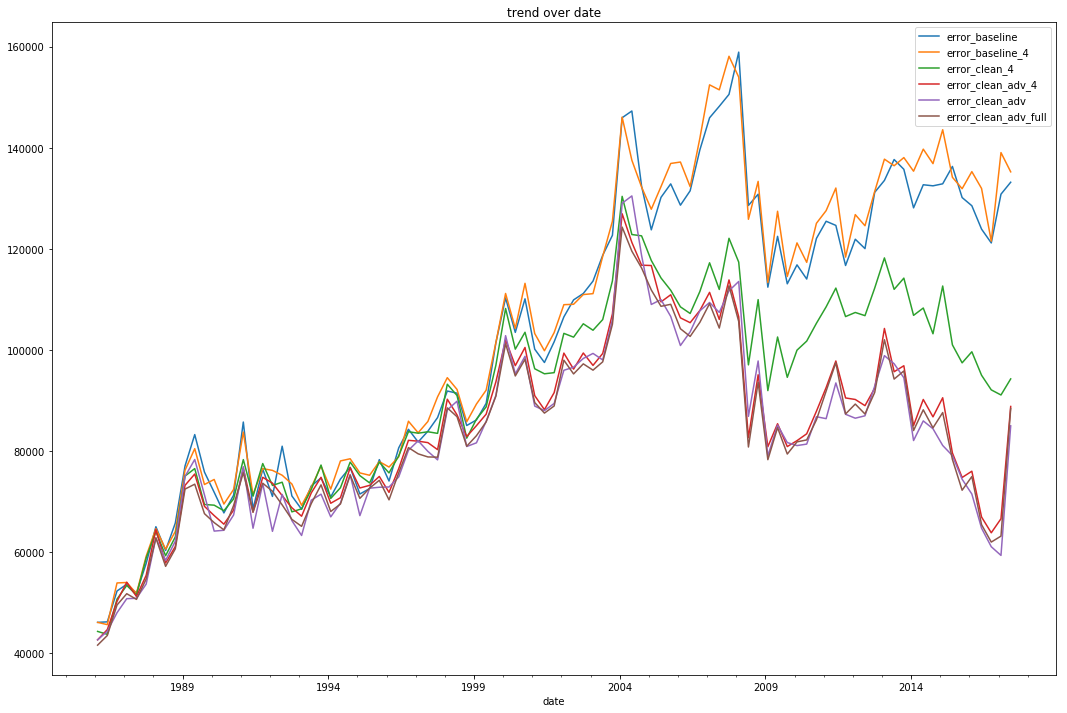

In [80]:
#df_cmp = df_cmp.join(df_clean_adv)
plot_trends(df_cmp, ['error_baseline', 'error_baseline_4', 'error_clean_4', 'error_clean_adv_4', 'error_clean_adv', 'error_clean_adv_full'])

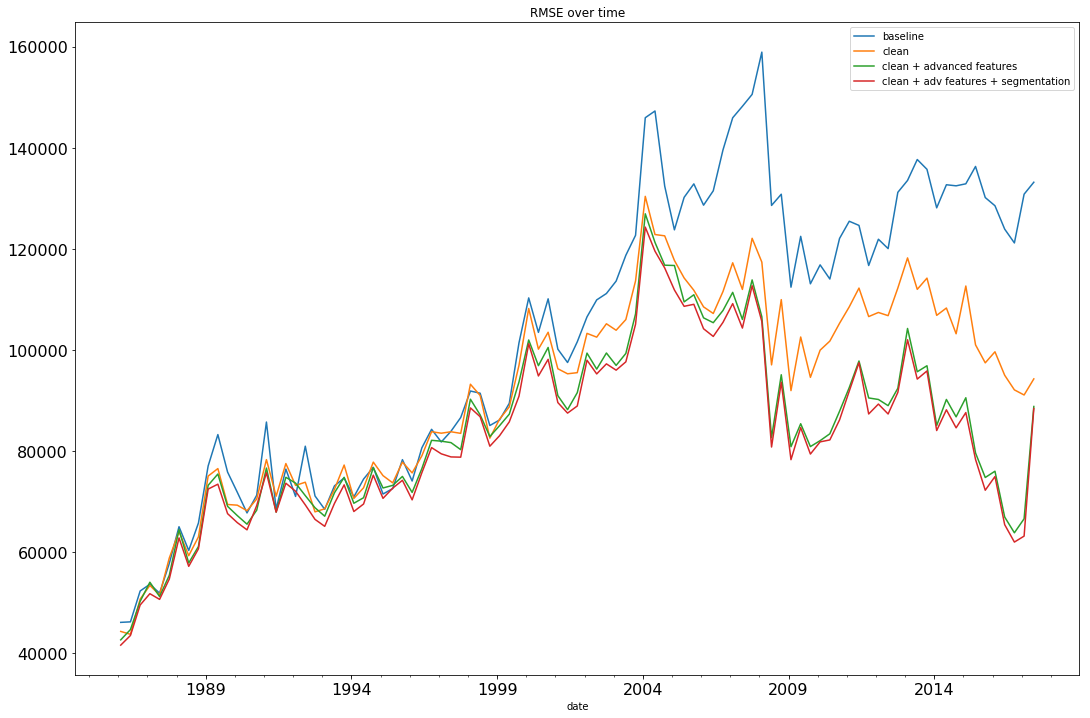

In [107]:
df_results = df_cmp[['error_baseline', 'error_clean_4', 'error_clean_adv_4', 'error_clean_adv_full']].copy()
df_results.columns = ['baseline', 'clean', 'clean + advanced features', 'clean + adv features + segmentation']
plot_trends(df_results,['baseline', 'clean', 'clean + advanced features', 'clean + adv features + segmentation'], title='RMSE over time')

### clean + adv features + segmentation

In [ ]:
df_all_adv_clean_seg = pp.dataset(feature_set=use_features+['eval'], valid=True, clean=True, date=('1985-10-01', '2017-10-01'))

In [67]:
rf_seg_mini = MultiSegmentRegressor(n_clusters=4, feature_set=use_features, cluster_features=['eval'])
mr_full_adv_seg_mini = ModelRegression(use_features+['eval'], rf_seg_mini)
rf_seg = MultiSegmentRegressor(n_clusters=4, feature_set=use_features, cluster_features=['eval'], n_estimators=100, max_depth=14)
mr_full_adv_seg = ModelRegression(use_features+['eval'], rf_seg)

In [68]:
mr_full_adv_seg_mini.regress(df_all_adv_clean_seg, sliding_window=4)
df_clean_adv_seg_4_mini = mr_full_adv_seg_mini.summary()
df_clean_adv_seg_4_mini.columns = ['error_clean_adv_seg_4', 'window_clean_adv_seg_4']
df_clean_adv_seg_4_mini.to_csv('c:\\wenyan\\dse_capstone\\notebooks\\modeling\\dump\\regress_clean_adv_seg_4_mini.csv')

[dp] train and predict - period: 1985-10-01 ~ 1986-05-30, sliding(in month): 4, test: 4, data shape: (25910, 28)
[dp] track/sliding/test window size: 13327, 0, 12583
[dp] training data size: (13327, 24)
[dp] test data size: (12583, 24)
[dp] train and predict - period: 1986-02-03 ~ 1986-09-30, sliding(in month): 4, test: 4, data shape: (29830, 28)
[dp] track/sliding/test window size: 12199, 0, 17631
[dp] training data size: (12199, 24)
[dp] test data size: (17631, 24)
[dp] train and predict - period: 1986-06-02 ~ 1987-01-30, sliding(in month): 4, test: 4, data shape: (35699, 28)
[dp] track/sliding/test window size: 17631, 0, 18068
[dp] training data size: (17631, 24)
[dp] test data size: (18068, 24)
[dp] train and predict - period: 1986-10-01 ~ 1987-05-29, sliding(in month): 4, test: 4, data shape: (33170, 28)
[dp] track/sliding/test window size: 17713, 0, 15457
[dp] training data size: (17713, 24)
[dp] test data size: (15457, 24)
[dp] train and predict - period: 1987-02-02 ~ 1987-09-30

[dp] train and predict - period: 1997-06-02 ~ 1998-01-30, sliding(in month): 4, test: 4, data shape: (26842, 28)
[dp] track/sliding/test window size: 14076, 0, 12766
[dp] training data size: (14076, 24)
[dp] test data size: (12766, 24)
[dp] train and predict - period: 1997-10-01 ~ 1998-05-29, sliding(in month): 4, test: 4, data shape: (27670, 28)
[dp] track/sliding/test window size: 12381, 0, 15289
[dp] training data size: (12381, 24)
[dp] test data size: (15289, 24)
[dp] train and predict - period: 1998-02-02 ~ 1998-09-30, sliding(in month): 4, test: 4, data shape: (32801, 28)
[dp] track/sliding/test window size: 14904, 0, 17897
[dp] training data size: (14904, 24)
[dp] test data size: (17897, 24)
[dp] train and predict - period: 1998-06-01 ~ 1999-01-29, sliding(in month): 4, test: 4, data shape: (31938, 28)
[dp] track/sliding/test window size: 17456, 0, 14482
[dp] training data size: (17456, 24)
[dp] test data size: (14482, 24)
[dp] train and predict - period: 1998-10-01 ~ 1999-05-30

[dp] test data size: (10814, 24)
[dp] train and predict - period: 2009-02-02 ~ 2009-09-30, sliding(in month): 4, test: 4, data shape: (23062, 28)
[dp] track/sliding/test window size: 10551, 0, 12511
[dp] training data size: (10551, 24)
[dp] test data size: (12511, 24)
[dp] train and predict - period: 2009-06-01 ~ 2010-01-29, sliding(in month): 4, test: 4, data shape: (23726, 28)
[dp] track/sliding/test window size: 12137, 0, 11589
[dp] training data size: (12137, 24)
[dp] test data size: (11589, 24)
[dp] train and predict - period: 2009-10-01 ~ 2010-05-28, sliding(in month): 4, test: 4, data shape: (22446, 28)
[dp] track/sliding/test window size: 10931, 0, 11515
[dp] training data size: (10931, 24)
[dp] test data size: (11515, 24)
[dp] train and predict - period: 2010-02-01 ~ 2010-09-30, sliding(in month): 4, test: 4, data shape: (22528, 28)
[dp] track/sliding/test window size: 11231, 0, 11297
[dp] training data size: (11231, 24)
[dp] test data size: (11297, 24)
[dp] train and predict 

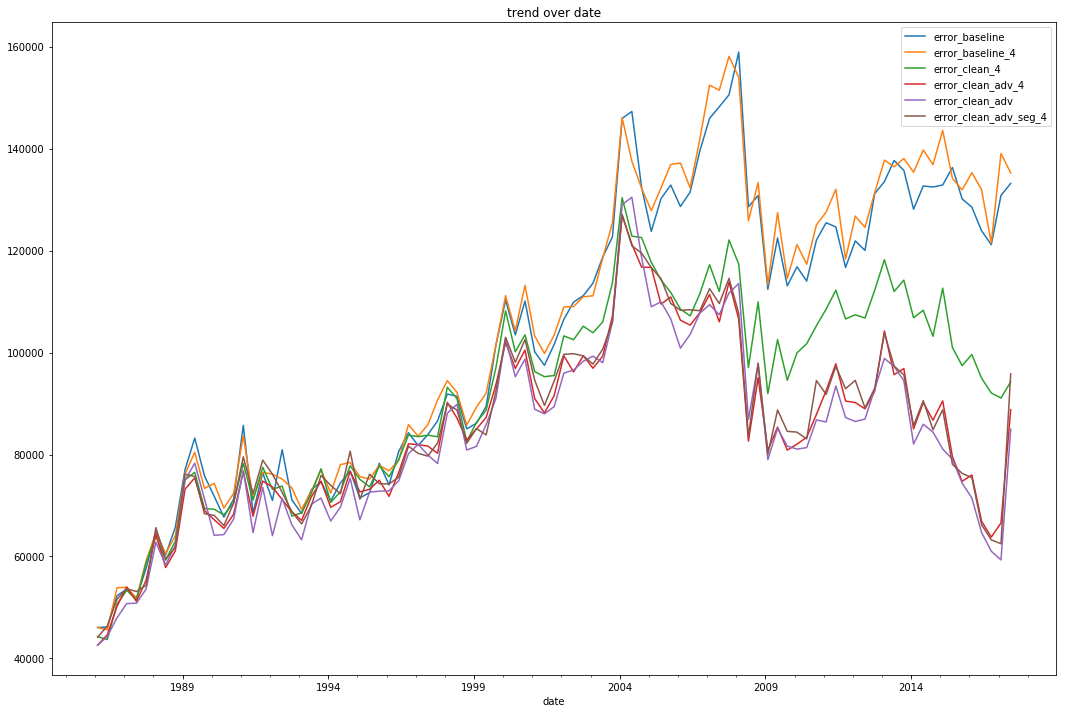

In [70]:
df_cmp = df_cmp.join(df_clean_adv_seg_4_mini)
plot_trends(df_cmp, ['error_baseline', 'error_baseline_4', 'error_clean_4', 'error_clean_adv_4', 'error_clean_adv', 'error_clean_adv_seg_4'])

In [ ]:
mr_full_adv_seg.regress(df_all_adv_clean_seg, sliding_window=4)
df_clean_adv_seg_4 = mr_full_adv_seg.summary()
df_clean_adv_seg_4.columns = ['error_clean_adv_seg_full_4', 'window_clean_adv_seg_full_4']
df_clean_adv_seg_4.to_csv('c:\\wenyan\\dse_capstone\\notebooks\\modeling\\dump\\regress_clean_adv_seg_4.csv')

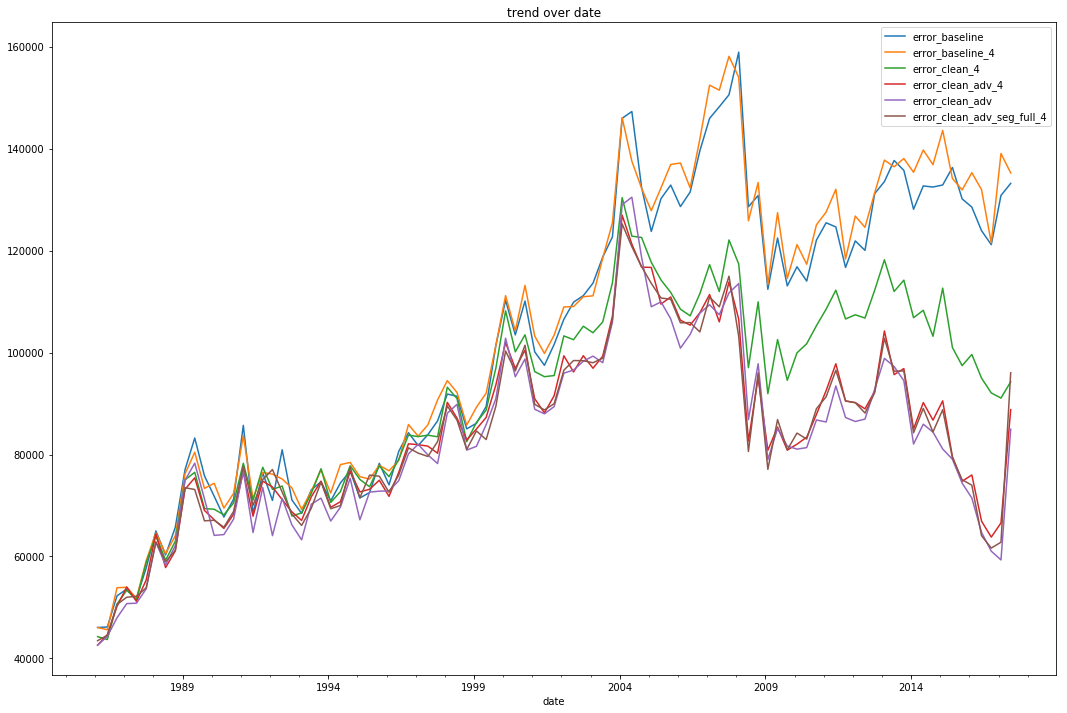

In [73]:
df_cmp = df_cmp.join(df_clean_adv_seg_4)
plot_trends(df_cmp, ['error_baseline', 'error_baseline_4', 'error_clean_4', 'error_clean_adv_4', 'error_clean_adv', 'error_clean_adv_seg_full_4'])

### prediction on properties

In [8]:
pp_gen = Preprocess(df_transaction, df_property, target='sold_price')
rf_mini = RandomForestRegressor(n_estimators=20, max_depth=12, n_jobs=-1, random_state=17)

mr_full_predict = ModelRegression(use_features, rf_mini)
mr_full_predict.regress(pp_gen, begin='2015-10-01', end='2017-10-01', sliding_window=4, predict=True)

[dp] preprocess dataset - transaction: (1477830, 38)
[dp] train and predict - period: 2015-10-01 ~ 2016-05-31, sliding(in month): 4, test: 4, data shape: (19157, 27)
[dp] track/sliding/test window size: 8763, 0, 10394
[dp] training data size: (8763, 23)
[dp] predict data size: (672016, 23)
[dp] preprocess dataset - transaction: (1477830, 38)
[dp] train and predict - period: 2016-02-01 ~ 2016-09-30, sliding(in month): 4, test: 4, data shape: (22297, 27)
[dp] track/sliding/test window size: 10227, 0, 12070
[dp] training data size: (10227, 23)
[dp] predict data size: (672016, 23)
[dp] preprocess dataset - transaction: (1477830, 38)
[dp] train and predict - period: 2016-06-01 ~ 2017-01-31, sliding(in month): 4, test: 4, data shape: (21123, 27)
[dp] track/sliding/test window size: 11871, 0, 9252
[dp] training data size: (11871, 23)
[dp] predict data size: (672031, 23)
[dp] preprocess dataset - transaction: (1477830, 38)
[dp] train and predict - period: 2016-10-03 ~ 2017-05-31, sliding(in mo

[33089.573971258076,
 32284.657984143087,
 29518.238189455413,
 30744.524391151597,
 29502.311645524027]

In [9]:
mr_full_predict.results.shape

(3360167, 3)

In [10]:
mr_full_predict = ModelRegression(use_features, rf_mini)
mr_full_predict.regress(pp_gen, begin='1983-10-01', end='2017-10-01', sliding_window=4, predict=True)

[dp] preprocess dataset - transaction: (1477830, 38)
[dp] train and predict - period: 1983-10-01 ~ 1984-05-31, sliding(in month): 4, test: 4, data shape: (19777, 27)
[dp] track/sliding/test window size: 9171, 0, 10606
[dp] training data size: (9171, 23)
[dp] predict data size: (660252, 23)
[dp] preprocess dataset - transaction: (1477830, 38)
[dp] train and predict - period: 1984-02-01 ~ 1984-09-28, sliding(in month): 4, test: 4, data shape: (21696, 27)
[dp] track/sliding/test window size: 10024, 0, 11672
[dp] training data size: (10024, 23)
[dp] predict data size: (660122, 23)
[dp] preprocess dataset - transaction: (1477830, 38)
[dp] train and predict - period: 1984-06-01 ~ 1985-01-31, sliding(in month): 4, test: 4, data shape: (20645, 27)
[dp] track/sliding/test window size: 11101, 0, 9544
[dp] training data size: (11101, 23)
[dp] predict data size: (660181, 23)
[dp] preprocess dataset - transaction: (1477830, 38)
[dp] train and predict - period: 1984-10-01 ~ 1985-05-31, sliding(in mo

[dp] train and predict - period: 1993-02-01 ~ 1993-09-30, sliding(in month): 4, test: 4, data shape: (17340, 27)
[dp] track/sliding/test window size: 7848, 0, 9492
[dp] training data size: (7848, 23)
[dp] predict data size: (671922, 23)
[dp] preprocess dataset - transaction: (1477830, 38)
[dp] train and predict - period: 1993-06-01 ~ 1994-01-31, sliding(in month): 4, test: 4, data shape: (18185, 27)
[dp] track/sliding/test window size: 9435, 0, 8750
[dp] training data size: (9435, 23)
[dp] predict data size: (671919, 23)
[dp] preprocess dataset - transaction: (1477830, 38)
[dp] train and predict - period: 1993-10-01 ~ 1994-05-31, sliding(in month): 4, test: 4, data shape: (18686, 27)
[dp] track/sliding/test window size: 8735, 0, 9951
[dp] training data size: (8735, 23)
[dp] predict data size: (671975, 23)
[dp] preprocess dataset - transaction: (1477830, 38)
[dp] train and predict - period: 1994-02-01 ~ 1994-09-30, sliding(in month): 4, test: 4, data shape: (20340, 27)
[dp] track/slidin

[dp] track/sliding/test window size: 16780, 0, 13887
[dp] training data size: (16780, 23)
[dp] predict data size: (672100, 23)
[dp] preprocess dataset - transaction: (1477830, 38)
[dp] train and predict - period: 2002-10-01 ~ 2003-05-30, sliding(in month): 4, test: 4, data shape: (29049, 27)
[dp] track/sliding/test window size: 13735, 0, 15314
[dp] training data size: (13735, 23)
[dp] predict data size: (672063, 23)
[dp] preprocess dataset - transaction: (1477830, 38)
[dp] train and predict - period: 2003-02-03 ~ 2003-09-30, sliding(in month): 4, test: 4, data shape: (33833, 27)
[dp] track/sliding/test window size: 15246, 0, 18587
[dp] training data size: (15246, 23)
[dp] predict data size: (672062, 23)
[dp] preprocess dataset - transaction: (1477830, 38)
[dp] train and predict - period: 2003-06-02 ~ 2004-01-30, sliding(in month): 4, test: 4, data shape: (34629, 27)
[dp] track/sliding/test window size: 18979, 0, 15650
[dp] training data size: (18979, 23)
[dp] predict data size: (672070

[dp] training data size: (8885, 23)
[dp] predict data size: (672099, 23)
[dp] preprocess dataset - transaction: (1477830, 38)
[dp] train and predict - period: 2012-02-01 ~ 2012-09-28, sliding(in month): 4, test: 4, data shape: (21824, 27)
[dp] track/sliding/test window size: 9843, 0, 11981
[dp] training data size: (9843, 23)
[dp] predict data size: (672084, 23)
[dp] preprocess dataset - transaction: (1477830, 38)
[dp] train and predict - period: 2012-06-01 ~ 2013-01-31, sliding(in month): 4, test: 4, data shape: (22114, 27)
[dp] track/sliding/test window size: 11604, 0, 10510
[dp] training data size: (11604, 23)
[dp] predict data size: (672013, 23)
[dp] preprocess dataset - transaction: (1477830, 38)
[dp] train and predict - period: 2012-10-01 ~ 2013-05-31, sliding(in month): 4, test: 4, data shape: (21876, 27)
[dp] track/sliding/test window size: 10675, 0, 11201
[dp] training data size: (10675, 23)
[dp] predict data size: (672014, 23)
[dp] preprocess dataset - transaction: (1477830, 3

[14535.694010347132,
 14728.43319315405,
 13470.574709749173,
 14472.966703323793,
 14063.504860463254,
 14718.190833971916,
 15232.345998159699,
 14521.444969985168,
 15149.792592922502,
 15042.155688431592,
 16808.881402422056,
 17966.551008139897,
 17454.49059581293,
 22071.065845310764,
 22457.911906408823,
 24126.501937109344,
 28482.006455469364,
 27762.831620768804,
 23387.414558905293,
 21882.963455235116,
 22461.3275479298,
 21546.788624842826,
 22694.153445515472,
 19842.182877573163,
 19945.803938777994,
 22266.891706652914,
 22470.816843849607,
 23246.516615933866,
 21220.64920415953,
 21003.319473320287,
 21477.185042106805,
 26123.072016813698,
 24669.744144396136,
 25709.14942126642,
 23285.773594628627,
 24920.832030492176,
 23653.701142747304,
 25509.4904009632,
 24709.36820989006,
 25287.20084433926,
 28039.776101008665,
 29060.710610051734,
 29301.015449158447,
 30001.130969268153,
 30812.20585454077,
 26165.121503497387,
 26441.43125229806,
 30257.786717012357,
 294

In [12]:
mr_full_predict.results.to_csv('c:\\wenyan\\dse_capstone\\notebooks\\modeling\\dump\\predict_full_4.csv')
